<a href="https://colab.research.google.com/github/Ziqi-Li/foss4g_22_glasgow/blob/main/notebooks/FOSS4G_MGWR_SIMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install geopandas
#!pip install mgwr 
#!pip install esda

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW
import matplotlib.pyplot as plt

In [3]:
glasgow_simd = gpd.read_file("https://raw.githubusercontent.com/Ziqi-Li/foss4g_23_glasgow/main/data/gla_simd.geojson")

In [4]:
glasgow_simd.columns

Index(['DataZone', 'dist_to_pa', 'income_dep', 'simd_perce', 'employment',
       'depress_ra', 'LBWT', 'attendance', 'not_partic', 'university',
       'broadband', 'crime_rate', 'overcrowde', 'nocentralh', 'geometry'],
      dtype='object')

In [5]:
glasgow_simd['depress_rate'] = glasgow_simd['depress_ra'].astype(float)
glasgow_simd['income_deprived_rate'] = glasgow_simd['income_dep'].astype(float)
glasgow_simd['dist_to_park'] = glasgow_simd['dist_to_pa'].astype(float)

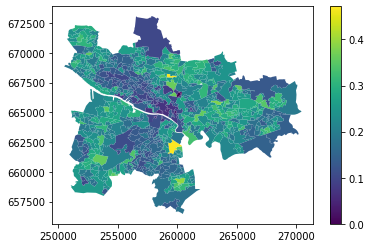

In [6]:
glasgow_simd.plot("depress_rate",legend=True)

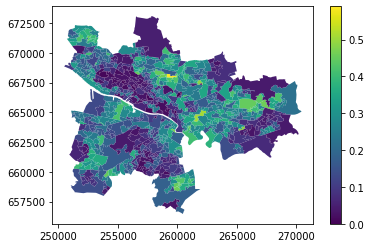

In [7]:
glasgow_simd.plot("income_deprived_rate",legend=True)

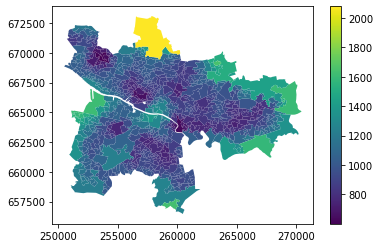

In [8]:
glasgow_simd.plot("dist_to_park",legend=True)

In [9]:
glasgow_simd['x'] = glasgow_simd.centroid.x
glasgow_simd['y'] = glasgow_simd.centroid.y


There is one missing record in the depression rate column, so we have to remove that row.

In [10]:
subset = glasgow_simd[['depress_rate','income_deprived_rate','dist_to_park','x','y','geometry']]

In [11]:
subset = subset.dropna()

Data prep

In [12]:
y = subset['depress_rate'].values.reshape(-1,1)
X = subset[['income_deprived_rate','dist_to_park']].values

In [13]:
coords = list(zip(subset['x'],subset['y']))

In [14]:
y = (y - y.mean(axis=0))/y.std(axis=0)
X = (X - X.mean(axis=0))/X.std(axis=0)

MGWR

In [15]:
mgwr_selector = Sel_BW(coords,y,X,multi=True)
mgwr_bw = mgwr_selector.search()
print("Optimal BW:",mgwr_bw)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Optimal BW: [ 51.  51. 743.]


In [16]:
mgwr_rslt = MGWR(coords,y,X,selector=mgwr_selector).fit()

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
mgwr_rslt.summary()

Model type                                                         Gaussian
Number of observations:                                                 744
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            263.255
Log-likelihood:                                                    -669.213
AIC:                                                               1344.427
AICc:                                                              1346.481
BIC:                                                              -4636.267
R2:                                                                   0.646
Adj. R2:                                                              0.645

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [18]:
mgwr_rslt.params[mgwr_rslt.filter_tvals() == 0] = np.nan

MGWR Viz

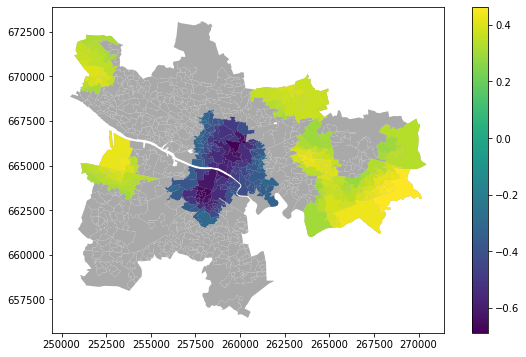

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='darkgrey',ax=ax)
subset.plot(mgwr_rslt.params[:,0], legend=True,ax=ax)

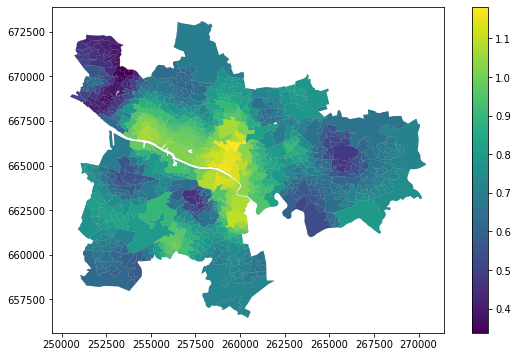

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='darkgrey',ax=ax)
subset.plot(mgwr_rslt.params[:,1], legend=True,ax=ax)

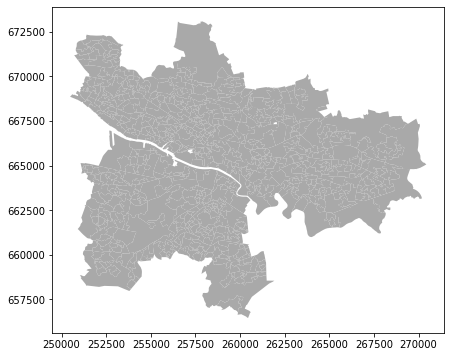

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))
subset.plot(color='darkgrey',ax=ax)
if np.sum(~np.isnan(mgwr_rslt.params[:,2])) > 0:
    subset.plot(mgwr_rslt.params[:,2], legend=True,ax=ax)

Examining residual autocorrelation in MGWR and OLS

In [22]:
import statsmodels.api as sm

X_cons = sm.add_constant(X)
ols_res = sm.OLS(y,X_cons).fit().resid

Text(0.5, 1.0, 'OLS Residuals')

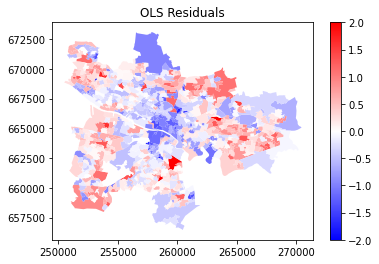

In [23]:
subset.plot(ols_res,legend=True,vmin=-2,vmax=2,cmap="bwr")
plt.title("OLS Residuals")

Text(0.5, 1.0, 'MGWR Residuals')

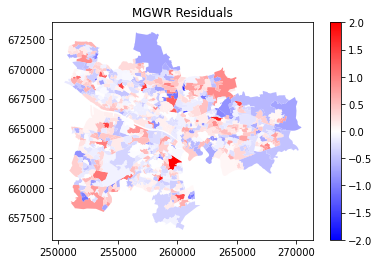

In [24]:
subset.plot(mgwr_rslt.resid_response,legend=True,vmin=-2,vmax=2,cmap="bwr")
plt.title("MGWR Residuals")

In [25]:
#!pip install esda

In [26]:
from esda.moran import Moran
from libpysal.weights import Queen

In [27]:
w_res = Queen.from_dataframe(subset)
w_res.transform = 'R'

/usr/local/lib/python3.7/dist-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [28]:
mgwr_mi = Moran(mgwr_rslt.resid_response,  w_res)
ols_mi = Moran(ols_res,  w_res)

In [29]:
print("OLS Moran's I:", ols_mi.I)
print("OLS Moran's I p-value:", ols_mi.p_sim)

OLS Moran's I: 0.29800790254533915
OLS Moran's I p-value: 0.001


In [30]:
print("MGWR Moran's I:", mgwr_mi.I)
print("MGWR Moran's I p-value:", mgwr_mi.p_sim)

MGWR Moran's I: 0.00493870894315133
MGWR Moran's I p-value: 0.405
